In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from data_loader import data_loader
import datetime

import model as Model
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [225]:
# load dataset
batch_size = 50
lr = 0.001
head = 1
root = 'E:'
gen = True
meta = False
#audio = "musicnn"
audio = None
lyric = "tf_idf"
#yric = 'bert'
#lyric = None
sub = False

loss_type = 'seq_cos'
seq_k = 10

use_music_embedding = False
check_baseline = False

echo_nest_sub_path = 'dataset/echo_nest/sub_data'
echo_nest_whole_path = 'dataset/echo_nest/data'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get task name from args configurations
def get_task_name(genre=False, meta=True, audio='musicnn', lyric=None):
    task_name = ""
    if genre is True:
        task_name += "genre_"
    if meta is True:
        task_name += "meta_"
    if audio is None:
        task_name += "none" + '_'
    else:
        task_name += audio + '_'
    if lyric is None:
        task_name += "none"
    else:
        task_name += lyric
    return task_name

# get sub task name for sub-folder
def get_sub_task_name(batch, lr, head):
    return "b_{}_lr_{}_head_{}".format(batch, lr, head)

# load batch size and learning rate
learning_rate = lr
# check if it is a sub-dataset for debugging and testing
if sub:
    work_folder_root = root + '/' + echo_nest_sub_path
else:
    work_folder_root = root + '/' + echo_nest_whole_path
# create work folder
task_name = get_task_name(gen, meta, audio, lyric)
work_folder = work_folder_root + '/' + task_name
if not os.path.exists(work_folder):
    os.makedirs(work_folder)
# create cache folder
cache_folder = work_folder + '/cache'
if not os.path.exists(cache_folder):
    os.makedirs(cache_folder)

dataset = data_loader.Dataset(dataset_root='E:', sub=sub, genre=gen, meta=meta, \
        audio=audio, lyric=lyric, outdir=cache_folder, dim_list=[0, 0, 200, 0])

music_embed_dim, music_embed_dim_list = dataset.get_dim()
print("dataset loaded:")
print("music embed dim: {} [{}, {}, {}, {}]".format(music_embed_dim, music_embed_dim_list[0], \
    music_embed_dim_list[1], music_embed_dim_list[2], music_embed_dim_list[3]))

# load train and valid set
train_data_list = dataset.get_data(set_tag='train', neg_samp=False)
x_train_len_list, y_train_len_list, x_train_tensor_list, y_train_tensor_list = \
    dataset.get_batched_data(train_data_list, batch_size=batch_size, fix_length=False)
x_train_tracks = train_data_list[2]
y_train_tracks = train_data_list[3]

valid_data_list = dataset.get_data(set_tag='valid', neg_samp=False)
# valid_data_batch =  len(valid_data_list[0])
valid_data_batch = batch_size
x_valid_len_list, y_valid_len_list, x_valid_tensor_list, y_valid_tensor_list = \
    dataset.get_batched_data(valid_data_list, batch_size=valid_data_batch, fix_length=False)

x_valid_tracks = valid_data_list[2]
y_valid_tracks = valid_data_list[3]

# load test set
# test_data_dict = dataset.get_data(set_tag='test')
# test_data_batch = batch_size
# test_batched_data_dict = {}
# x_test_tracks_dict = {}
# y_test_tracks_dict = {}
# for key in test_data_dict.keys():
#     x_test_len_list, y_test_len_list, x_test_tensor_list, y_test_tensor_list = \
#         dataset.get_batched_data(test_data_dict[key], batch_size=test_data_batch, fix_length=False)
#     test_batched_data_dict[key] = [x_test_len_list, y_test_len_list, x_test_tensor_list, y_test_tensor_list]
#     print("{} playlists found for {}".format(len(x_test_len_list) * test_data_batch, key))
#     x_test_tracks_dict[key] = test_data_dict[key][2]
#     y_test_tracks_dict[key] = test_data_dict[key][3]
    
# load model
model = Model.UserAttention(music_embed_dim, music_embed_dim_list, \
    return_seq=True if loss_type=='seq_cos' else False, seq_k=seq_k, re_embed=use_music_embedding, \
    check_baseline=check_baseline)

# load checkpoint
# check if checkpoint exists
sub_task_name = get_sub_task_name(batch_size, lr, head)
checkpoint_final_path = work_folder + '/' + sub_task_name + '.pt'
if os.path.isfile(checkpoint_final_path):
    checkpoint = torch.load(checkpoint_final_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    best_valid_loss = checkpoint['valid_loss']
    print("Checkpoint found, start from epoch {}, loss: {}, valid loss:{}"\
        .format(start_epoch, loss, best_valid_loss))

# move model to device
model = nn.DataParallel(model) # designed for multi-GPUs
model = model.to(device)

# load recommender
if loss_type == 'seq_cos':
    recommender_valid = Model.MusicRecommenderSequenceEmbed(dataset, device, mode='train', \
        model=model, use_music_embedding=use_music_embedding)
else:
    recommender_valid = Model.MusicRecommender(dataset, device, mode='train', model=model, \
        use_music_embedding=use_music_embedding)

if loss_type == 'seq_cos':
    recommender_test = Model.MusicRecommenderSequenceEmbed(dataset, device, mode='test', \
        model=model, use_music_embedding=use_music_embedding)
else:
    recommender_test = Model.MusicRecommender(dataset, device, mode='test', model=model, \
        use_music_embedding=use_music_embedding)

Load existed song dictionary cache successfully!
Load existed genre dictionary cache successfully!
Load existed genre matrix cache successfully!
Load existed lyric feature matrix cache successfully!
Load existed song matrix cache successfully!
Load existed train song dictionary and matrix cache successfully!
Load existed test song dictionary and matrix cache successfully!
Load existed train matrix cache successfully!
Load existed valid matrix cache successfully!
Load existed test matrix cache successfully!
dataset loaded:
music embed dim: 329 [201, 0, 0, 128]
Checkpoint found, start from epoch 104, loss: 0.07891424983769862, valid loss:0.14157154441992892
52419 songs in test set: old: 44083 (84.0973692744997%) ,new: 8336 (15.902630725500297%)


In [182]:
# get task name from args configurations
def get_task_name(genre=False, meta=True, audio='musicnn', lyric=None):
    task_name = ""
    if genre is True:
        task_name += "genre_"
    if meta is True:
        task_name += "meta_"
    if audio is None:
        task_name += "none" + '_'
    else:
        task_name += audio + '_'
    if lyric is None:
        task_name += "none"
    else:
        task_name += lyric
    return task_name


# visualize user embedding, user liked songs, and song embedding distribution
class Visualizer(object):
    
    def __init__(self, dataset, normalize=True):
        self.song_mat = dataset.song_mat
        # pca song mat to 2d
        U, S, self.V = torch.pca_lowrank(torch.tensor(self.song_mat), q=2)
        self.normalize = normalize
        self.song_mat = torch.matmul(torch.tensor(self.song_mat), self.V[:, :2]).numpy()
        #elf.song_mat = self.to_2d(self.song_mat)
        self.V = self.V.to(torch.float32)
        
        self.center = self.song_mat.mean(axis=0)
        
        print("Visualizer init")
        
    def to_2d(self, mat):
        mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()
        if self.normalize:
            # standardize to 1
            mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)
        else:
            mat = mat - self.center
        return mat
    
    def evaluate(self, model, x_tensor_list, y_tensor_list, x_len_list, y_len_list, x_tracks, y_tracks, recommender):
        self.x = x_tensor_list
        self.y = y_tensor_list
        self.x_track = x_tracks
        self.y_track = y_tracks
        self.pred_list = []
        self.recom_list = []
        self.recom_id_list = []
        self.recall_list = []
        self.matched_list = []
        # check mode
        mode = recommender.mode
        #for i in tqdm(range(len(x_tensor_list))):
        for i in tqdm(range(2)):
            # get x and y
            x = x_tensor_list[i].to(device)
            x_len = x_len_list[i]
            y = y_tensor_list[i].to(device)
            y_len = y_len_list[i]
            _batch_size = x.shape[0]
            # generate mask for attention
            x_mask = Model.generate_mask(x_len).to(device)
            # generate mask for y to calculate loss
            y_mask = Model.generate_out_mask(y_len).to(device)
            x_y_mask = Model.generate_out_mask(x_len).to(device)
            # set to evaluation
            model.eval()
            # prediction
            pred = model(x, x_mask)
            self.pred_list.append(pred)
            # recommendation
            if mode == 'train':
                top_10_track_ids, top_10_track_mats, recalls, others = \
                    recommender.recommend(pred, x_tracks[i * _batch_size: (i + 1)*_batch_size], y_tracks[i * _batch_size: (i + 1)*_batch_size], return_songs=True)
                self.recom_list.append(top_10_track_mats)
                self.recom_id_list.append(top_10_track_ids)
            elif mode == 'test':
                top_10_track_ids, top_10_track_mats, recalls, recalls_old, recalls_new, others = \
                    recommender.recommend(pred, x_tracks[i * _batch_size: (i + 1)*_batch_size], y_tracks[i * _batch_size: (i + 1)*_batch_size], return_songs=True)
                self.recom_list.append(top_10_track_mats)
                self.recom_id_list.append(top_10_track_ids)
            # recall 100 for each user
            for u in range(batch_size):
                # get recalls for the user
                top_k_track = set(self.recom_id_list[i][u])
                gt_set = set(self.y_track[i * batch_size + u])
                inter_set = top_k_track & gt_set
                self.recall_list.append(len(inter_set) / len(gt_set))
                self.matched_list.append(list(inter_set))
    
    def get_user_embed(self, user_idx):
        return self.pred_list[int(user_idx/batch_size)][user_idx - batch_size * int(user_idx/batch_size)]
                
    def visualize(self, idx, user_embed_num=10, plot=True, normalize=True):
        batch_idx, user_idx = int(idx / batch_size), idx - int(idx / batch_size) * batch_size
        #user_embed = self.pred_list[batch_idx][user_idx].to('cpu').detach().numpy()
        #liked_song = self.x[batch_idx][user_idx].to('cpu').detach().numpy()
        #masked_song = self.y[batch_idx][user_idx].to('cpu').detach().numpy()
        user_embed = self.pred_list[batch_idx][user_idx].to('cpu').to(torch.float32)
        liked_song = self.x[batch_idx][user_idx].to('cpu').to(torch.float32)
        masked_song = self.y[batch_idx][user_idx].to('cpu').to(torch.float32)
        # To 2d
        user_embed = self.to_2d(user_embed)
        liked_song = self.to_2d(liked_song)
        masked_song = self.to_2d(masked_song)
        # get recalls for the user
        print('user id: {}, recalls: @100: {}, matched: {} / {}'\
              .format(idx, self.recall_list[idx], len(self.matched_list[idx]), len(self.y_track[idx])))
        # standardize
        if plot:
            plt.figure()
            #plt.scatter(user_embed[:, 0], user_embed[:, 1], label='user embedding')
            
            if self.normalize:
                if user_embed_num > 0:
                    plt.plot([0, user_embed[0, 0]], [0, user_embed[0, 1]], color='steelblue', label='user embedding')
                for j in range(1, user_embed_num):
                    #print(user_embed[j, 0],user_embed[j, 1])
                    plt.plot([0, user_embed[j, 0]], [0, user_embed[j, 1]], color='steelblue')
            
            plt.scatter(liked_song[:, 0], liked_song[:, 1], label='given songs', color='seagreen')
            plt.scatter(masked_song[:, 0], masked_song[:, 1], label='masked songs', color='orange')
            plt.axis('equal')
            plt.legend()
            plt.savefig('{}.pdf'.format(idx))
            plt.show()
        return liked_song, masked_song, user_embed
    

In [147]:
# evaluate validation data without normalization ----------------------------------------------------------------------------
visual = Visualizer(dataset, normalize=False)
visual.evaluate(model, x_valid_tensor_list, y_valid_tensor_list, x_valid_len_list, y_valid_len_list, x_valid_tracks, y_valid_tracks, recommender_valid)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Visualizer init


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.45s/it]


In [148]:
visual.center

array([0.2020775, 0.0020818])

[ 0 61 21 60 59 54 25 64 50 29 44 31 32 43 34 28 17 18 76  1  2 93 85 84
 83 77 16 42 74 73 11 12 70 69 68 35 51 49 23 52 98 71 96 39 36 41 47  6
 53 45 48  9 79 40 15 10 14 26 33 58 62 57 65 67 95 97 99 91 72  7 24 30
 27 86 19 13  5 81 22 90  4 20 37 55 80 63 88 87 92  8  3 78 94 82 38 75
 66 89 56 46]
48
top_k: [46 56 89 66 75 38 82 94 78  3  8 92 87 88 63 80 55 37 20  4]
bottom_k: [ 0 61 21 60 59 54 25 64 50 29 44 31 32 43 34 28 17 18 76  1]
Recall = 0:  35.0 35.0%
Recall > 0:  65.0 65.0%
0.13814926525098667


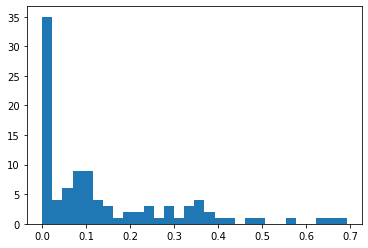

In [149]:
k = 20

args = np.argsort(np.array(visual.recall_list))

print(args)
print(args[int(len(args) / 2)])

top_k_arg = args[-k:]
bottom_k_arg = args[:k]
print('top_k:', np.flip(top_k_arg))
print('bottom_k:', bottom_k_arg)

num = plt.hist(visual.recall_list, bins=30)
print('Recall = 0: ', num[0][0], "{}%".format(num[0][0] * 100 / (num[0][0] + num[0][1:].sum())))
print('Recall > 0: ',num[0][1:].sum(), "{}%".format(num[0][1:].sum() * 100 / (num[0][0] + num[0][1:].sum())))
print(sum(visual.recall_list)/len(visual.recall_list))

Database musicdbn has already been existed.
Table echonest has already been existed.
Table echofilter has already been existed.
Table millionsonglink has already been existed.
Table spotify has already been existed.
Table songs has already been existed.
user id: 46, recalls: @100: 0.6923076923076923, matched: 9 / 13
user id: 56, recalls: @100: 0.6666666666666666, matched: 16 / 24
user id: 99, recalls: @100: 0.125, matched: 3 / 24
user id: 91, recalls: @100: 0.14285714285714285, matched: 4 / 28
user id: 0, recalls: @100: 0.0, matched: 0 / 11
user id: 61, recalls: @100: 0.0, matched: 0 / 9


<ipython-input-146-b05c0306ad82>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()


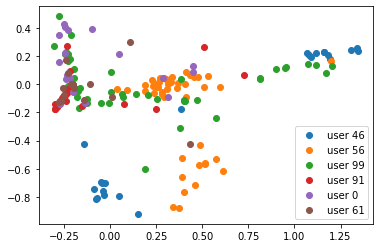

In [150]:
from data_loader import musicdb
import json

db = musicdb.MusicDB()

def get_max_genre(stats):
    stats = json.loads(stats)
    if len(stats.keys()) == 0:
        return []
    inverse = [(value, key) for key, value in stats.items()]
    return(max(inverse)[1])

user_id_list = [46, 56, 99, 91, 0, 61]
#user_id_list = [74, 81, 92, 73, 0, 61]
plt.figure()
for user_id in user_id_list:
    liked_song, masked_song, _ = visual.visualize(user_id, user_embed_num=5, plot=False, normalize=False)
    #print(liked_song.shape)
    #print(masked_song.shape)
    all_song = np.concatenate([liked_song, masked_song], axis=0)
    #plt.scatter(liked_song[:, 0], liked_song[:, 1], label='user {} liked songs'.format(user_id))
    #plt.scatter(masked_song[:, 0], masked_song[:, 1], label='user {} masked songs'.format(user_id))
    #plt.scatter(all_song[:, 0], all_song[:, 1], label='user {}, match:{}/{}'.format(user_id, len(visual.matched_list[user_id]), len(y_valid_tracks[user_id])))
    plt.scatter(all_song[:, 0], all_song[:, 1], label='user {}'.format(user_id))
#     for track in x_valid_tracks[user_id]:
#         song_dict = db.select_song_spotify(track)
#         print("title: {}, \t\tgenre: {}".format(song_dict['track_name'], get_max_genre(song_dict['genre_top'])))
#     print("-----------------------------------------------------------------")
#     for track in y_valid_tracks[user_id]:
#         song_dict = db.select_song_spotify(track)
#         print("title: {}, \t\tgenre: {}".format(song_dict['track_name'], get_max_genre(song_dict['genre_top'])))
    
plt.legend()

# save to pdf file
task_name = get_task_name(gen, meta, audio, lyric)
plt.savefig("{}.pdf".format(task_name))

plt.show()


    

['rock', 'indie', 'heavy metal', 'punk', 'electronic', 'alternative', 'Progressive metal', 'indie rock', '80s', 'pop', 'Grunge', 'folk', 'punk rock', 'classic rock', 'death metal', 'hard rock', 'thrash metal', 'metal', 'soul', 'Progressive rock', 'Power metal', 'female vocalists', 'new wave', 'ska', 'acoustic', 'alternative rock', 'singer-songwriter', 'reggae', 'Hip-Hop', 'Melodic Death Metal', '60s', 'cover', 'trip-hop', 'country', 'jazz', 'blues', 'post-punk', 'funk', 'new age', 'synthpop']


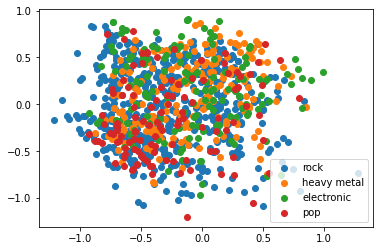

In [226]:
# visualize song mat with same genre tags

N = 5000
song_mat = dataset.song_mat
song_dict = dataset.song_dict
song_json = dataset.song_json

# convert song_mat to 2D space
U, S, V = torch.pca_lowrank(torch.tensor(song_mat), q=2)
song_mat = torch.matmul(torch.tensor(song_mat), V[:, :2]).numpy()
V = V.to(torch.float32)
center = song_mat.mean(axis=0)
song_mat = song_mat - center

counter = 0

genre_dict = {}

def add_genre_mat(genre_dict, genre, num):
    if genre is None:
        return genre_dict
    if genre in genre_dict.keys():
        genre_dict[genre].append(num)
    else:
        genre_dict[genre] = []
        genre_dict[genre].append(num)
    return genre_dict

def get_genre_tag(track):
    stats = json.loads(song_json[track]['genre_top'])
    if len(stats.keys()) == 0:
        return None
    inverse = [(value, key) for key, value in stats.items()]
    return(max(inverse)[1])

for track in song_dict.keys():
    genre_tag = get_genre_tag(track)
    genre_dict = add_genre_mat(genre_dict, genre_tag, song_dict[track])
    counter += 1
    if counter > N:
        break

def comp(item):
    return item[0]


K = 40
# find the top K tags
inverse_genre_dict = [(len(value), key) for key, value in genre_dict.items()]
inverse_genre_dict.sort(key=comp, reverse=True)
top_k_genre_tag = [inverse_genre_dict[i][1] for i in range(K)]
print(top_k_genre_tag)

plt.figure()
genre_id_list = [0, 2, 4, 9]

for i in range(len(genre_id_list)):
    genre_tag = inverse_genre_dict[genre_id_list[i]][1]
    song_num_list = genre_dict[genre_tag]
    x_pos = []
    y_pos = []
    for num in song_num_list:
        x_pos.append(song_mat[num][0])
        y_pos.append(song_mat[num][1])
    plt.scatter(x_pos, y_pos, label=genre_tag)
    
fig_name = get_task_name(gen, meta, audio, lyric)
plt.legend()
plt.savefig("{}_genre_disp.pdf".format(fig_name))
plt.show()
    

In [227]:
def get_user_genre_dist(user_id):
    x_tracks = x_valid_tracks[user_id]
    y_tracks = y_valid_tracks[user_id]
    x_genre_dict, y_genre_dict = {}, {}
    for track in x_tracks:
        genre_tag = get_genre_tag(track)
        x_genre_dict = add_genre_mat(x_genre_dict, genre_tag, song_dict[track])
    for track in y_tracks:
        genre_tag = get_genre_tag(track)
        y_genre_dict = add_genre_mat(y_genre_dict, genre_tag, song_dict[track])
    print("User {}: ----------------------------".format(user_id))
    for genre in x_genre_dict.keys():
        print("{} : {}".format(genre, len(x_genre_dict[genre])))
    print("-------------------------------------")
    for genre in y_genre_dict.keys():
        print("{} : {}".format(genre, len(y_genre_dict[genre])))
    
get_user_genre_dist(0)

User 0: ----------------------------
indie rock : 1
electronic : 2
classic rock : 1
trip-hop : 2
post-rock : 1
Alt-country : 1
dance : 1
-------------------------------------
heavy metal : 1
rnb : 1
alternative : 1
electronic : 2
new wave : 1
indie rock : 1
hip hop : 1
rap : 1
70s : 1


In [228]:
get_user_genre_dist(61)

User 61: ----------------------------
electronic : 1
death metal : 1
Soundtrack : 1
trance : 2
80s : 1
Gothic : 1
-------------------------------------
pop : 1
trance : 1
instrumental : 1
sad : 1
metal : 1
death metal : 1
black metal : 1
old school : 1
